In [34]:
!pip install scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/4e/ba/ce9bd1cd4953336a0e213b29cb80bb11816f2a93de8c99f88ef0b446ad0c/scikit_learn-1.3.2-cp311-cp311-win_amd64.whl.metadata
  Using cached scikit_learn-1.3.2-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Obtaining dependency information for joblib>=1.1.1 from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Obtaining dependency information for threadpoolctl>=2.0.0 from https://files.pythonhosted.org/packages/81/12/fd4dea011af9d69e1cad05c75f3f7202cdcbeac9b712eea58ca779a72865/threadpoolctl-3.2.0-py3-none-any.whl.metadata
  Using cached threadpoolctl-3.2.0-py3-none-any.whl.metadata (10.0 kB)
Using cached scikit_learn-1.3.2-cp311-cp311-win_amd64.whl (9.2 MB)
Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
Using cached threadpoolctl-3.2


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\Ashwin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [209]:
class DatasetProcessor:
    def __init__(self, name):
        self.df = pd.read_csv(name).fillna(0)

    def calculate_innings_stats(self):
        self.df["innings_total"] = self.df.groupby(["match_id", "innings"])["runs_off_bat"].transform("cumsum") + self.df.groupby(["match_id", "innings"])["extras"].transform("cumsum")
        self.df["wicket"] = (self.df["wicket_type"] != 0).astype(int)
        self.df["innings_wickets"] = self.df.groupby(["match_id", "innings"])["wicket"].transform("cumsum")
        
        self.df["ball"] = self.df["ball"].astype(int) * 6 + (self.df["ball"] - self.df["ball"].astype(int)) * 10
        self.df["outcome"] = self.df.apply(lambda ball : 7 if ball["wicket"] == 1 else ball["runs_off_bat"], axis=1)

    def calculate_striker_stats(self):
        self.df["striker_runs"] = self.df.groupby(["match_id", "striker"])["runs_off_bat"].transform("cumsum")
        self.df["striker_balls"] = self.df.groupby(["match_id", "striker"])["runs_off_bat"].transform("cumcount")

    def calculate_bowler_stats(self):
        self.df["bowler_runs"] = self.df.groupby(["match_id", "bowler"])["runs_off_bat"].transform("cumsum")
        self.df["bowler_balls"] = self.df.groupby(["match_id", "bowler"])["runs_off_bat"].transform("cumcount")
        self.df["bowler_wickets"] = self.df.groupby(["match_id", "bowler"])["wicket"].transform("cumsum")

    def select_season(self, season):
        self.df = self.df[self.df.season == season]

    def process(self):
        self.select_season(2023)
        self.calculate_innings_stats()
        self.calculate_striker_stats()
        self.calculate_bowler_stats()

        return self.df[["season", 
                        "venue", 
                        "innings", 
                        "innings_total",
                        "innings_wickets",
                        "ball", 
                        "striker",
                        "striker_runs", 
                        "striker_balls",
                        "bowler",
                        "bowler_runs",
                        "bowler_balls",
                        "bowler_wickets", 
                        "runs_off_bat",
                        "outcome"]]

In [224]:
class ExpectedModel:
    def __init__(self, dataset):
        self.dataset = dataset

    def train(self):
        X = ["innings_total",
             "innings_wickets",
             "ball", 
             "striker_runs", 
             "striker_balls",
             "bowler_runs",
             "bowler_balls",
             "bowler_wickets"]
        
        Y = "outcome"

        pipeline = make_pipeline(StandardScaler(),
                                 MLPClassifier())
        
        dummies = pd.get_dummies(self.dataset[Y])
        X_train, X_test, y_train, y_test = train_test_split(self.dataset[X], dummies, test_size=0.25)
        pipeline.fit(X_train, y_train)

        return pipeline

In [225]:
p = DatasetProcessor("IPL_ball_by_ball_updated.csv")
df = p.process()
trainer = ExpectedModel(df)

In [226]:
model = trainer.train()

C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [278]:
X = ["innings_total",
             "innings_wickets",
             "ball", 
             "striker_runs", 
             "striker_balls",
             "bowler_runs",
             "bowler_balls",
             "bowler_wickets"]

xR = (model.predict_proba(df[X]) * np.array([[0, 1, 2, 3, 4, 5, 6, 0]])).sum(axis=1)
df["preds"] = xR

C:\Users\Ashwin\AppData\Local\Temp\ipykernel_4476\3328016233.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["preds"] = xR


C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

<Axes: xlabel='ball', ylabel='runs_off_bat'>

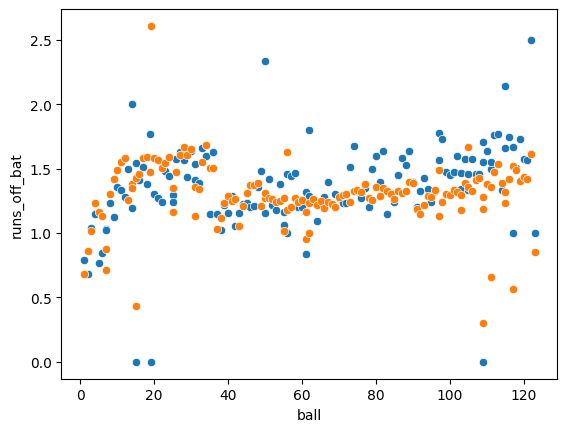

In [260]:
ball_group = df.groupby("ball", as_index=False).agg({ "runs_off_bat": "mean", "preds": "mean" })
sns.scatterplot(data=ball_group, x="ball", y="runs_off_bat")
sns.scatterplot(data=ball_group, x="ball", y="preds")

C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

<Axes: xlabel='striker_runs', ylabel='runs_off_bat'>

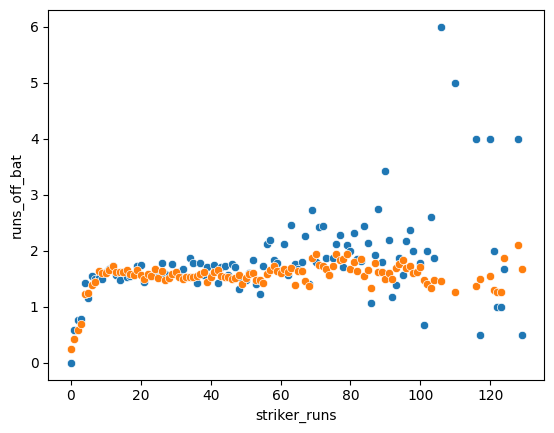

In [254]:
runs_group = df.groupby("striker_runs", as_index=False).agg({ "runs_off_bat": "mean", "preds": "mean" })
sns.scatterplot(data=runs_group, x="striker_runs", y="runs_off_bat")
sns.scatterplot(data=runs_group, x="striker_runs", y="preds")

C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

<Axes: xlabel='innings_total', ylabel='runs_off_bat'>

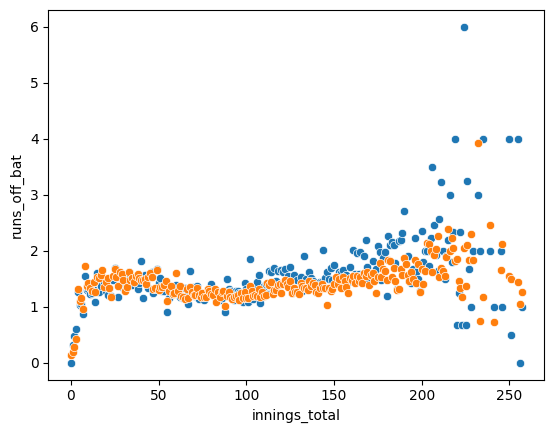

In [253]:
total_group = df.groupby("innings_total", as_index=False).agg({ "runs_off_bat": "mean", "preds": "mean" })
sns.scatterplot(data=total_group, x="innings_total", y="runs_off_bat")
sns.scatterplot(data=total_group, x="innings_total", y="preds")

In [313]:
dummies = pd.get_dummies(df["outcome"]).astype(int)


df[dummies.columns] = dummies
df.groupby("bowler", as_index=False)[[0,1,2,3,4,5,6,7]].sum().sort_values(by=7, ascending=False)

C:\Users\Ashwin\AppData\Local\Temp\ipykernel_4476\592469036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[dummies.columns] = dummies


,bowler,0,1,2,3,4,5,6,7
77,MM Sharma,62,115,16,0,28,0,16,31
82,Mohammed Shami,178,90,27,3,56,0,21,28
108,Rashid Khan,111,173,29,0,40,0,26,28
123,TU Deshpande,141,91,30,0,54,0,28,24
96,PP Chawla,103,161,22,1,42,0,19,23
...,...,...,...,...,...,...,...,...,...
60,KR Sen,6,9,0,0,3,0,1,0
84,Mohit Rathee,3,3,1,0,3,0,2,0
80,MW Short,12,10,0,0,2,0,1,0
67,M Ashwin,4,11,3,1,2,0,4,0
